In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
from collections import Counter
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Load the training data
df = pd.read_csv("../data/training_data.csv")

# Define features (X) and target variable (y)
X = df.drop(['class', 'main_elements'], axis=1)
y = df['class']
groups = df['main_elements']

# Initialize the RandomForest model
model = RandomForestClassifier(random_state=0, n_jobs=-1)

# Define the cross-validation strategy (StratifiedGroupKFold)
skf = StratifiedGroupKFold(n_splits=10, random_state=None, shuffle=False)

# Initialize metrics for precision, recall, F1-score, and support
metrics_sum = np.zeros((4, 3))

# Define a list to hold the confusion matrices from each fold
confusion_matrices = []

# Begin cross-validation
for train_index, test_index in skf.split(X, y, groups):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute precision, recall, F1-score, and support for the current fold
    metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
    
    # Accumulate the metrics over all folds
    metrics_sum += np.array(metrics)

    # Compute the confusion matrix for the current fold and store it
    cm = confusion_matrix(y_test, y_pred)
    
    # Store the confusion matrix for the current fold
    confusion_matrices.append(cm)

# Calculate average metrics over all folds
metrics_avg = metrics_sum / skf.get_n_splits()
precision_avg, recall_avg, fscore_avg, support_avg = metrics_avg

# Print the aggregate classification report
print('Aggregate Classification Report:')
for i, class_name in enumerate(np.unique(y)):
    print(f"\nClass {class_name}:")
    print(f'Precision: {precision_avg[i]:.3f}')
    print(f'Recall: {recall_avg[i]:.3f}')
    print(f'F1-score: {fscore_avg[i]:.3f}')
    print(f'Support: {support_avg[i]:.3f}')

# Train a final model on the entire dataset
final_model = RandomForestClassifier(random_state=0, n_jobs=-1)
final_model.fit(X, y)

# Extract feature importances from the final model
importances = final_model.feature_importances_

# Identify the top 10 features based on their importances
top_indices = np.argsort(importances)[-10:]
top_features = X.columns[top_indices]
top_importances = importances[top_indices]

# Save the final trained model to a pickle file for future use
filename = 'imba_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))

# Compute the sum of confusion matrices over all folds
sum_confusion_matrix = np.sum(confusion_matrices, axis=0)

# Compute normalized confusion matrix
normalized_confusion_matrix = sum_confusion_matrix.astype('float') / sum_confusion_matrix.sum(axis=1)[:, np.newaxis]

Aggregate Classification Report:

Class 0:
Precision: 0.898
Recall: 0.935
F1-score: 0.916
Support: 13940.200

Class 1:
Precision: 0.513
Recall: 0.333
F1-score: 0.376
Support: 2170.300

Class 2:
Precision: 0.746
Recall: 0.642
F1-score: 0.647
Support: 781.300


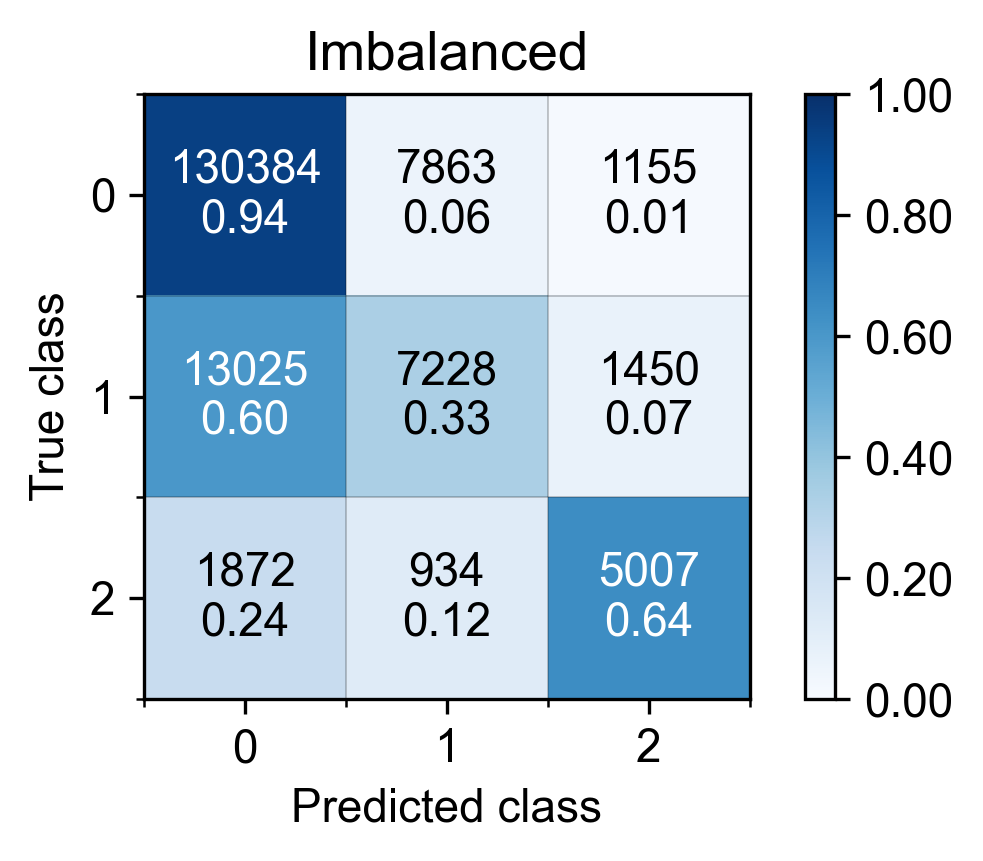

In [2]:
plt.rcParams['font.size'] = 11
plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Plot the confusion matrix with total number of cases
fig, ax = plt.subplots(figsize=(4, 3), dpi=300, tight_layout=True)

# Use the normalized confusion matrix for color mapping
# Set vmin and vmax to control the color range
cax = ax.imshow(normalized_confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

# Add colorbar with 2 decimal place format
plt.colorbar(cax, format='%.2f')

# Define tick marks
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))

# Define threshold for deciding text color
thresh = normalized_confusion_matrix.max() / 2.0

# Iterate over each cell in the confusion matrix and add the text
for i, j in itertools.product(range(sum_confusion_matrix.shape[0]), range(sum_confusion_matrix.shape[1])):
    plt.text(j, i, f"{sum_confusion_matrix[i, j]}\n{normalized_confusion_matrix[i, j]:.2f}",
             horizontalalignment="center", 
             verticalalignment="center",  
             color="white" if normalized_confusion_matrix[i, j] > thresh else "black")

# Set minor ticks
ax.set_xticks(np.arange(-.5, len(np.unique(y)), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(np.unique(y)), 1), minor=True)
ax.set_title("Imbalanced")

# Draw gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=0.1)

# Set labels
plt.ylabel('True class')
plt.xlabel('Predicted class')

# Save figure and display it
plt.savefig('confusion_matrix_imba_model.png')
plt.show()

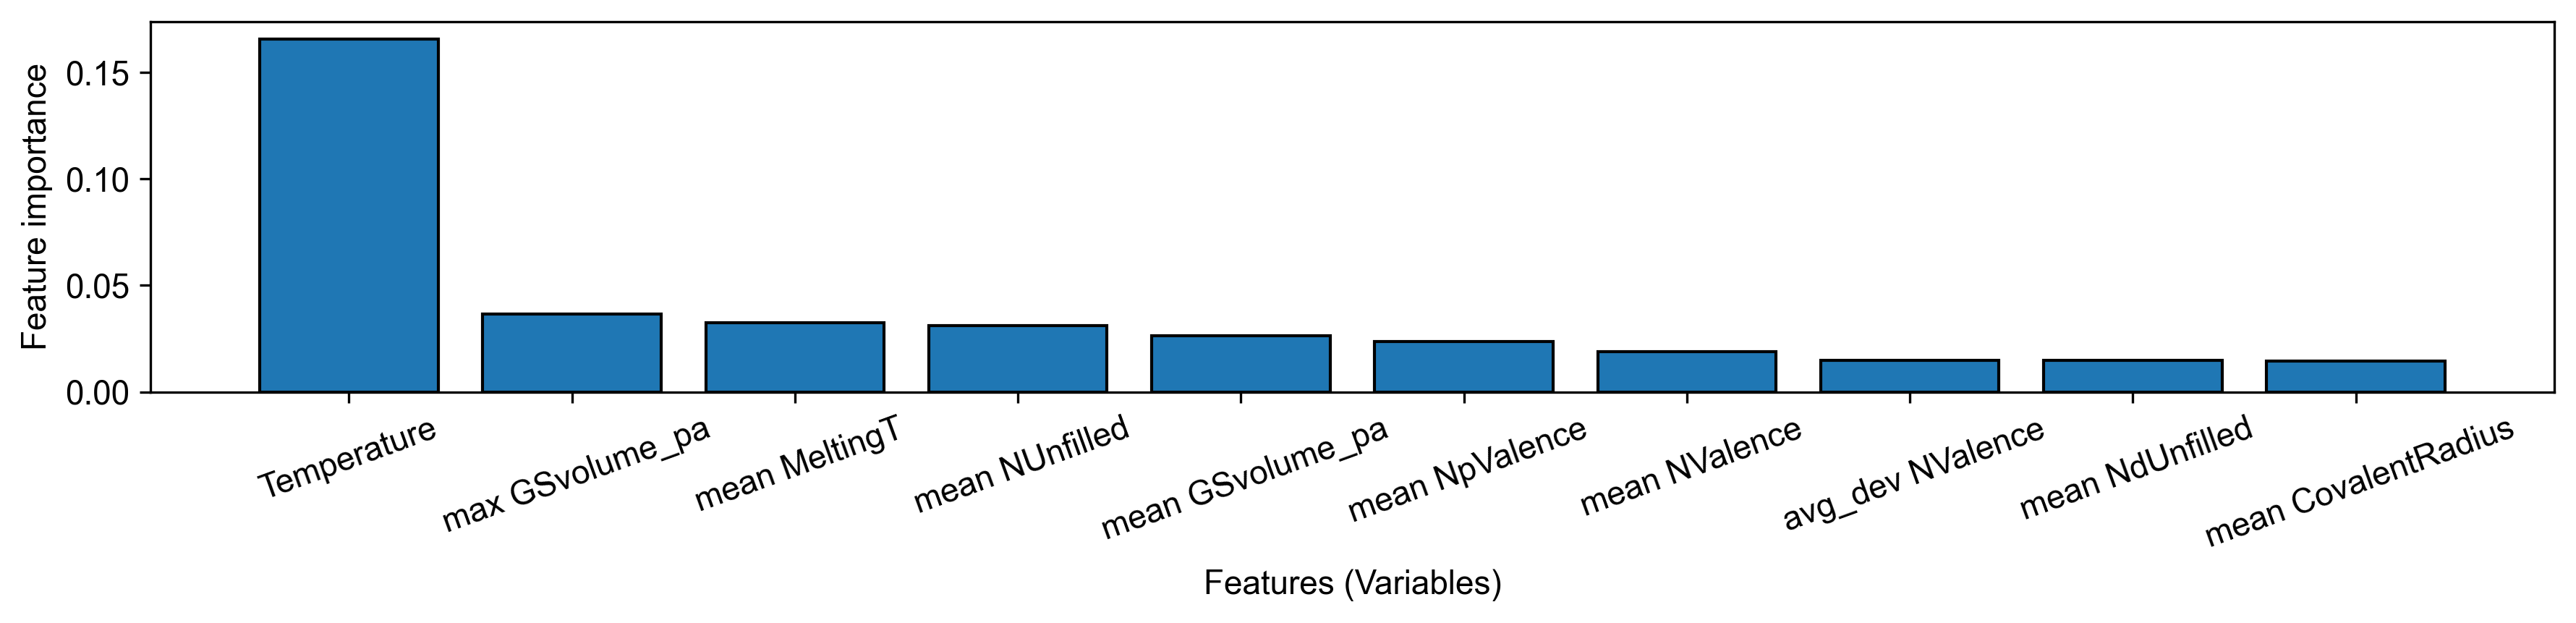

In [3]:
# Clean up the feature names
top_features = pd.Series(X.columns[top_indices]).str.replace("MagpieData", "").str.replace("maximum", "max")

# Sort features and importances by the importances
sort_indices = np.argsort(top_importances)[::-1]  # note the [::-1] for reversing
top_features_sorted = top_features[sort_indices]
top_importances_sorted = top_importances[sort_indices]

# Define the plot
fig, ax = plt.subplots(figsize=(12,3), dpi=300, tight_layout=True)

# Create a bar plot
ax.bar(top_features_sorted, top_importances_sorted, edgecolor='black')

# Set labels
ax.set_xlabel('Features (Variables)')
ax.set_ylabel('Feature importance')

# Set up y-axis formatting
formatter = matplotlib.ticker.FormatStrFormatter('%1.2f')
locator_y = matplotlib.ticker.MaxNLocator(nbins=4, steps=[1,2,5,10])
ax.yaxis.set_major_locator(locator_y)
ax.yaxis.set_major_formatter(formatter)

# Set x-axis rotation
ax.tick_params(axis='x', rotation=20)

# Save and display the plot
plt.savefig("feature_importance_imba_model.png")
plt.show()